In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

In [2]:
df = pd.read_csv('Liverpool_events.csv')
df.head()

,id,event_id,minute,second,team_id,team_name,player_id,x,y,end_x,end_y,is_touch,is_shot,is_goal,type,outcome,period,name,shirt_no,position
0,2744720053,3,0,0,36,Leverkusen,299684,50.0,50.0,34.2,45.4,True,False,False,Pass,Successful,FirstHalf,Exequiel Palacios,25,MC
1,2744720087,4,0,5,36,Leverkusen,369446,45.9,48.7,40.7,71.4,True,False,False,Pass,Successful,FirstHalf,Edmond Tapsoba,12,DC
2,2744720113,5,0,7,36,Leverkusen,134946,40.7,71.4,42.1,87.3,True,False,False,Pass,Successful,FirstHalf,Jonathan Tah,4,DC
3,2744720151,6,0,9,36,Leverkusen,404832,42.6,88.5,100.0,79.7,True,False,False,Pass,Unsuccessful,FirstHalf,Piero Hincapié,3,DC
4,2744720297,4,0,22,26,Liverpool,95408,5.0,61.1,3.5,49.6,True,False,False,Pass,Successful,FirstHalf,Virgil van Dijk,4,DC


In [3]:
df.position.unique()

array(['MC', 'DC', 'GK', 'DMR', 'DL', 'FW', 'FWL', 'DML', 'DR', 'FWR',
       'Sub'], dtype=object)

In [4]:
#Change color variables here:

team_color = '#c8102E' 
background_color = '#ffffff' #f7f7f7
node_color = '#b20000' #d3d3d3 #ff7f7f #ffe5e5
lines = '#4f4f4f' 

In [5]:
#Filter for one team - Liverpool
df = df[df['team_name'] == 'Liverpool']

In [6]:
#First half Pass Network

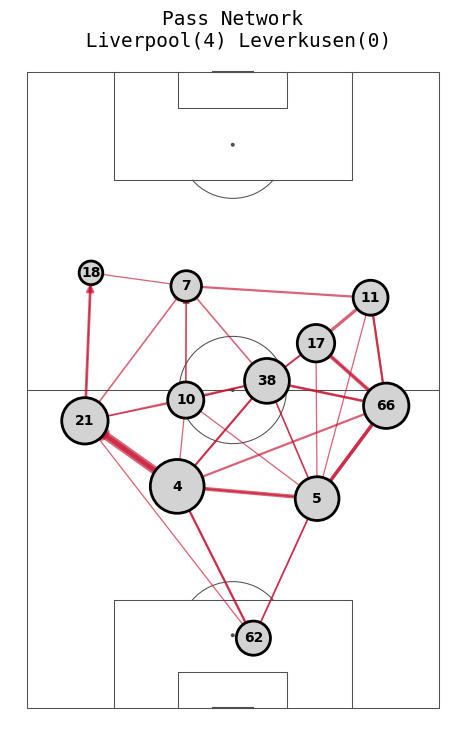

In [7]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Unique player information
unique_player_shirt_numbers = df[['player_id', 'shirt_no']]
unique_player_name = df[['player_id', 'name']]

# Adding 'newsecond' for sorting by time and identifying pass events
df['newsecond'] = 60 * df['minute'] + df['second']
df = df.sort_values(by=['newsecond'])

# Shifting player_id to get the recipient of the pass
df['passer'] = df['player_id']
df['recipient'] = df['passer'].shift(-1)

# Filtering for passes and successful passes
passes_df = df[df['type'] == 'Pass']
completions = passes_df[passes_df['outcome'] == 'Successful']

## Handling substitutions
sub_df = df[df['position'] == 'Sub']
first_half_subs = sub_df[sub_df['minute'] < 45]

## Exclude completions involving first half substitutions
subs_player_ids = first_half_subs['player_id'].unique()
completions = completions[~completions['passer'].isin(subs_player_ids)]
completions = completions[~completions['recipient'].isin(subs_player_ids)]

## Handling substitutions
sub_df = df[df['position'] == 'Sub']
first_sub = sub_df['newsecond'].min()
if first_sub <= (60 * 45):
    first_sub = 60 * 45
completions = completions[completions['newsecond'] < first_sub]

# Grouping by passer to get average location and count of passes
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Grouping by passer and recipient to get pass count
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# Merging average locations with pass counts
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Filtering for a minimum number of passes to plot
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

# Function to plot pass lines with varying thickness
def pass_line_template(ax, x, y, end_x, end_y, line_color, width):
    ax.annotate(
        '',
        xy=(end_y, end_x),
        xytext=(y, x),
        zorder=1,
        arrowprops=dict(arrowstyle='-|>', linewidth=width, color=line_color, alpha=.65)
    )

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, width, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, width=width)

# Drawing the pitch
fig, ax = plt.subplots(figsize=(12, 7))
pitch = VerticalPitch(pitch_type='opta', pitch_color=background_color, line_color=lines, linewidth=0.75)
pitch.draw(ax=ax)

plt.tight_layout()


# Plotting pass lines with varying thickness
for index, row in passes_between.iterrows():
    width = row['pass_count'] / passes_between['pass_count'].max() * 6  # scale width relative to max pass count
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], '#c8102E', width)

# Plotting nodes with size relative to the count of passes
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # scale node size
pitch.scatter(
    average_locs_and_count.x, average_locs_and_count.y, s=node_sizes, c='#d3d3d3',
    edgecolors="black", linewidth=2, alpha=1, ax=ax, zorder=2
)

# Annotating shirt numbers on the nodes
for index, row in average_locs_and_count.iterrows():
    shirt_no = unique_player_shirt_numbers[unique_player_shirt_numbers['player_id'] == row.name]['shirt_no'].values[0]
    pitch.annotate(
        shirt_no,
        xy=(row.x, row.y),
        c='black', 
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax
    )

ax.set_title('Pass Network\n Liverpool(4) Leverkusen(0)', fontsize=14, fontdict={'family': 'monospace'}, c='black')


plt.show()


In [8]:
## Second Half Pass Network

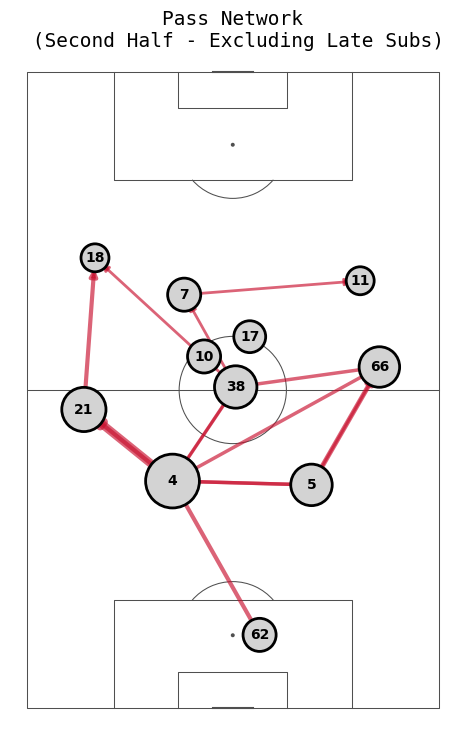

In [9]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Filter to only include passes from the second half
df = df[df['minute'] >= 45]

# Unique player information
unique_player_shirt_numbers = df[['player_id', 'shirt_no']]
unique_player_name = df[['player_id', 'name']]

# Adding 'newsecond' for sorting by time and identifying pass events
df['newsecond'] = 60 * df['minute'] + df['second']
df = df.sort_values(by=['newsecond'])

# Shifting player_id to get the recipient of the pass
df['passer'] = df['player_id']
df['recipient'] = df['passer'].shift(-1)

# Filtering for passes and successful passes
passes_df = df[df['type'] == 'Pass']
completions = passes_df[passes_df['outcome'] == 'Successful']

# Handling substitutions
sub_df = df[df['position'] == 'Sub']  # Identify substitution events
late_subs = sub_df[sub_df['minute'] >= 80]  # Substitutions in the last 10 minutes
late_sub_player_ids = late_subs['player_id'].unique()

# Exclude completions involving late substitutions
completions = completions[~completions['passer'].isin(late_sub_player_ids)]
completions = completions[~completions['recipient'].isin(late_sub_player_ids)]

# Grouping by passer to get average location and count of passes
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Grouping by passer and recipient to get pass count
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# Merging average locations with pass counts
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Filtering for a minimum number of passes to plot
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

# Function to plot pass lines with varying thickness
def pass_line_template(ax, x, y, end_x, end_y, line_color, width):
    ax.annotate(
        '',
        xy=(end_y, end_x),
        xytext=(y, x),
        zorder=1,
        arrowprops=dict(arrowstyle='-|>', linewidth=width, color=line_color, alpha=.65)
    )

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, width, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, width=width)

# Drawing the pitch
fig, ax = plt.subplots(figsize=(12, 7))
pitch = VerticalPitch(pitch_type='opta', pitch_color=background_color, line_color=lines, linewidth=0.75)
pitch.draw(ax=ax)

plt.tight_layout()

# Plotting pass lines with varying thickness
for index, row in passes_between.iterrows():
    width = row['pass_count'] / passes_between['pass_count'].max() * 6  # scale width relative to max pass count
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], '#c8102E', width)

# Plotting nodes with size relative to the count of passes
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # scale node size
pitch.scatter(
    average_locs_and_count.x, average_locs_and_count.y, s=node_sizes, c='#d3d3d3',
    edgecolors="black", linewidth=2, alpha=1, ax=ax, zorder=2
)

# Annotating shirt numbers on the nodes
for index, row in average_locs_and_count.iterrows():
    shirt_no = unique_player_shirt_numbers[unique_player_shirt_numbers['player_id'] == row.name]['shirt_no'].values[0]
    pitch.annotate(
        shirt_no,
        xy=(row.x, row.y),
        c='black', 
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax
    )

ax.set_title('Pass Network\n (Second Half - Excluding Late Subs)', fontsize=14, fontdict={'family': 'monospace'}, c='black')

plt.show()


In [ ]:
#Pass Network for specific player

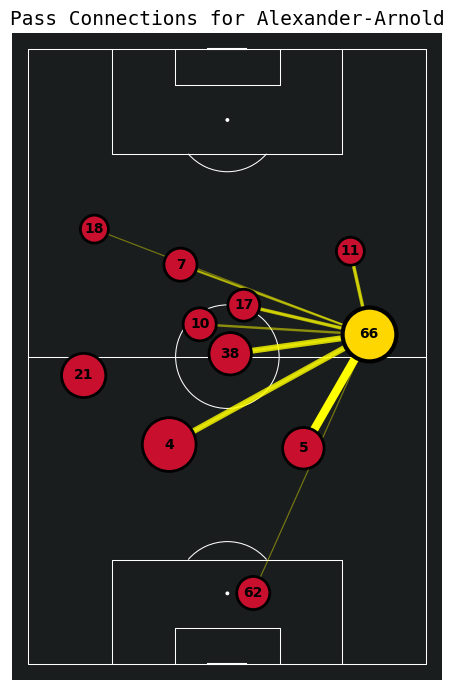

In [45]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Define the target player's ID (replace with the actual ID)
target_player_id = 318871  # Example player ID

# Filter passes involving the target player
target_completions = completions[
    (completions['passer'] == target_player_id) | (completions['recipient'] == target_player_id)
]

# Group by passer and recipient to calculate pass counts
target_passes_between = target_completions.groupby(['passer', 'recipient']).id.count().reset_index()
target_passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# Merge with average locations for plotting
target_passes_between = target_passes_between.merge(
    average_locs_and_count, left_on='passer', right_index=True
)
target_passes_between = target_passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# Drawing the pitch
fig, ax = plt.subplots(figsize=(12, 7))
pitch = VerticalPitch(pitch_type='opta', pitch_color=background_color2, line_color=lines2, linewidth=0.75)
pitch.draw(ax=ax)

# Highlight the target player with a distinct color
target_node_color = '#FFD700'  # Gold color for the target player
connection_color_base = '#FFFF00'  # Base color for connections

# Normalize the pass count for color intensity
max_pass_count = target_passes_between['pass_count'].max()

# Plot connections involving the target player
for index, row in target_passes_between.iterrows():
    width = row['pass_count'] / max_pass_count * 6
    alpha = 0.3 + (row['pass_count'] / max_pass_count * 0.7)  # Scale alpha for darkness (0.3 to 1.0)
    
    ax.annotate(
        '',
        xy=(row['y_end'], row['x_end']),
        xytext=(row['y'], row['x']),
        arrowprops=dict(
            arrowstyle='-|>',
            color=connection_color_base,
            lw=width,
            alpha=alpha,  # Adjust alpha for intensity
        ),
        zorder=1,
    )

# Plot nodes for all connected players
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500
pitch.scatter(
    average_locs_and_count.x, average_locs_and_count.y, s=node_sizes, c=team_color, edgecolors="black", linewidth=2, ax=ax
)

# Highlight the target player node
target_location = average_locs_and_count.loc[target_player_id]
pitch.scatter(
    target_location.x,
    target_location.y,
    s=1500,
    c=target_node_color,
    edgecolors="black",
    linewidth=3,
    ax=ax,
    zorder=3,
)

# Annotating shirt numbers
for index, row in average_locs_and_count.iterrows():
    shirt_no = unique_player_shirt_numbers[unique_player_shirt_numbers['player_id'] == row.name]['shirt_no'].values[0]
    pitch.annotate(
        shirt_no,
        xy=(row.x, row.y),
        c='black',
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax,
    )

# Title for the pass network
#ax.set_title(
    #f'Pass Connections for Player {name}',
    #fontsize=14,
    #fontdict={'family': 'monospace'},
    #c='black',
#)

# Retrieve the player's name using the target_player_id
player_full_name = unique_player_name.loc[unique_player_name['player_id'] == target_player_id, 'name'].values[0]
player_last_name = player_full_name.split()[-1]  # Extract the last name

# Title for the pass network
ax.set_title(
    f'Pass Connections for {player_last_name}',
    fontsize=14,
    fontdict={'family': 'monospace'},
    c='black',
)



plt.tight_layout()
plt.show()


In [47]:
#fig.savefig('/Users/Trymso/Desktop/TrentAA.png', dpi=300, bbox_inches='tight')

In [39]:
# Display the number of passes between the target player and others
pass_counts = target_passes_between[
    (target_passes_between['passer'] == target_player_id) | (target_passes_between['recipient'] == target_player_id)
]

# Sort by pass count (descending) for better readability
pass_counts = pass_counts.sort_values(by='pass_count', ascending=False)

# Display the result
pass_counts.head()


,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
11,345957,318871.0,7,35.104545,30.918182,22,53.609524,14.461905,21
0,95408,318871.0,5,35.705405,64.608108,37,53.609524,14.461905,21
8,318871,363884.0,5,53.609524,14.461905,21,50.473913,49.286957,23
5,318871,345957.0,4,53.609524,14.461905,21,35.104545,30.918182,22
3,318871,108226.0,3,53.609524,14.461905,21,67.150000,19.110000,10


In [43]:
# Total passes between Trent Alexander-Arnold and other players
total_passes = target_passes_between[
    (target_passes_between['passer'] == target_player_id) | 
    (target_passes_between['recipient'] == target_player_id)
]['pass_count'].sum()

print(f"Total passes involving {player_name}: {total_passes}")

Total passes involving Trent Alexander-Arnold: 42


In [53]:
# Define the target player's ID
target_player_id = 318871  # Example: Trent Alexander-Arnold

# Retrieve the player's name using the target_player_id
player_name = unique_player_name.loc[unique_player_name['player_id'] == target_player_id, 'name'].values[0]

# Filter passes where the target player is the passer or recipient
target_interactions = target_passes_between[
    (target_passes_between['passer'] == target_player_id) | (target_passes_between['recipient'] == target_player_id)
]

# Add names for both passer and recipient
target_interactions = target_interactions.merge(
    unique_player_name, left_on='passer', right_on='player_id', suffixes=('', '_passer')
)
target_interactions.rename(columns={'name': 'passer_name'}, inplace=True)

target_interactions = target_interactions.merge(
    unique_player_name, left_on='recipient', right_on='player_id', suffixes=('', '_recipient')
)
target_interactions.rename(columns={'name': 'recipient_name'}, inplace=True)

# Ensure no duplicates in the data
target_interactions = target_interactions.drop_duplicates(subset=['passer_name', 'recipient_name', 'pass_count'])

# Sum passes sent and received for the target player
total_interactions = target_interactions.groupby(['passer_name', 'recipient_name'])['pass_count'].sum().reset_index()

# Filter only rows involving the target player
filtered_interactions = total_interactions[
    (total_interactions['passer_name'] == player_name) | (total_interactions['recipient_name'] == player_name)
]

# Sort by total passes (descending)
filtered_interactions = filtered_interactions.sort_values(by='pass_count', ascending=False)

# Display the result
filtered_interactions


,passer_name,recipient_name,pass_count
2,Ibrahima Konaté,Trent Alexander-Arnold,7
12,Trent Alexander-Arnold,Ryan Gravenberch,5
14,Virgil van Dijk,Trent Alexander-Arnold,5
9,Trent Alexander-Arnold,Ibrahima Konaté,4
8,Trent Alexander-Arnold,Curtis Jones,3
11,Trent Alexander-Arnold,Mohamed Salah,3
1,Curtis Jones,Trent Alexander-Arnold,2
3,Luis Díaz,Trent Alexander-Arnold,2
4,Mohamed Salah,Trent Alexander-Arnold,2
5,Ryan Gravenberch,Trent Alexander-Arnold,2


In [13]:
df.name.unique()

array(['Curtis Jones', 'Ryan Gravenberch', 'Caoimhín Kelleher',
       'Virgil van Dijk', 'Cody Gakpo', 'Luis Díaz', 'Kostas Tsimikas',
       'Alexis Mac Allister', 'Trent Alexander-Arnold', 'Mohamed Salah',
       'Ibrahima Konaté', 'Dominik Szoboszlai', 'Darwin Núñez',
       'Andy Robertson', 'Conor Bradley', 'Jarell Quansah'], dtype=object)